In [1]:
import pandas as pd

In [2]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2d971534d987a5d850fe9a3a75c918cc03f0521d4288e8376676a13f492c278d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [4]:
import random 
import numpy as np
import torch
    
def random_seed(dls,seed_value):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    dls.rng.seed(seed_value)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [5]:
from fastai.vision.all import *
pd.options.mode.chained_assignment = None
train = pd.read_csv('../input/csv-files-for-microsoft-rice-disease/Train.csv')
test = pd.read_csv('../input/csv-files-for-microsoft-rice-disease/Test.csv')
submission = pd.read_csv("../input/csv-files-for-microsoft-rice-disease/SampleSubmission.csv")

In [6]:
train

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast
...,...,...
5335,id_zz6gzk7p97_rgn.jpg,brown
5336,id_zz8ca2p67e.jpg,blast
5337,id_zz8ca2p67e_rgn.jpg,blast
5338,id_zzt8y9q0x0.jpg,brown


In [7]:
unique_label = train['Label'].unique()
unique_label

array(['blast', 'brown', 'healthy'], dtype=object)

In [8]:
train['Label'].value_counts()

blast      2988
brown      1532
healthy     820
Name: Label, dtype: int64

In [9]:
train = train[~train.Image_id.str.contains('_rgn')]
train.reset_index(inplace=True,drop=True)
test = test[~test.Image_id.str.contains('_rgn')]
test.reset_index(inplace=True,drop=True)

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['Label']=le.fit_transform(train['Label'])

In [11]:
img=Image.open('../input/microsoft-rice-disease-classification-challenge/id_004wknd7qd_rgn.jpg') # View one image and check the files are present
img.shape

(1500, 2000)

In [12]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_allocated()
import gc; gc.collect()

133

In [13]:
!nvidia-smi

Wed Aug  3 20:58:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
!pip install timm
from timm import create_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 KB 9.4 MB/s eta 0:00:00


In [15]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [16]:
import albumentations
def get_train_aug(): return albumentations.Compose([
            #albumentations.HueSaturationValue(
                #hue_shift_limit=0.2, 
                #sat_shift_limit=0.2, 
                #val_shift_limit=0.2, 
                #p=0.5
            #),
            albumentations.CoarseDropout(p=0.5),
            albumentations.RandomContrast(p = 0.6)
])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.472987,0.276216,0.089888,0.910112,05:23


Better model found at epoch 0 with valid_loss value: 0.27621570229530334.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.300329,0.213575,0.076779,0.923221,05:24
1,0.241219,0.162120,0.061798,0.938202,05:24
2,0.250311,0.148619,0.052434,0.947566,05:24
3,0.167350,0.126633,0.043071,0.956929,05:24
4,0.148244,0.111628,0.041199,0.958802,05:24
5,0.127174,0.104761,0.039326,0.960674,05:25
6,0.106361,0.108227,0.031835,0.968165,05:24
7,0.066143,0.084010,0.031835,0.968165,05:25
8,0.076948,0.066891,0.022472,0.977528,05:24
9,0.080886,0.072824,0.020599,0.979401,05:24


Better model found at epoch 0 with valid_loss value: 0.21357540786266327.
Better model found at epoch 1 with valid_loss value: 0.16211996972560883.
Better model found at epoch 2 with valid_loss value: 0.1486193984746933.
Better model found at epoch 3 with valid_loss value: 0.12663280963897705.
Better model found at epoch 4 with valid_loss value: 0.11162836849689484.
Better model found at epoch 5 with valid_loss value: 0.10476129502058029.
Better model found at epoch 7 with valid_loss value: 0.08401039987802505.
Better model found at epoch 8 with valid_loss value: 0.06689105182886124.
Better model found at epoch 10 with valid_loss value: 0.06035209074616432.
Better model found at epoch 12 with valid_loss value: 0.059453096240758896.
Better model found at epoch 16 with valid_loss value: 0.05790266767144203.


0.07425337033945852


fold fineshed


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.443247,0.414007,0.161049,0.838951,05:25


Better model found at epoch 0 with valid_loss value: 0.41400742530822754.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.248423,0.204991,0.071161,0.928839,05:25
1,0.200906,0.159650,0.054307,0.945693,05:24
2,0.187353,0.129657,0.050562,0.949438,05:26
3,0.152109,0.103816,0.037453,0.962547,05:25
4,0.134454,0.160668,0.059925,0.940075,05:25
5,0.106386,0.101644,0.033708,0.966292,05:26
6,0.114463,0.129447,0.043071,0.956929,05:26
7,0.062189,0.085069,0.022472,0.977528,05:26
8,0.035902,0.060517,0.020599,0.979401,05:25
9,0.029939,0.074301,0.026217,0.973783,05:25


Better model found at epoch 0 with valid_loss value: 0.20499134063720703.
Better model found at epoch 1 with valid_loss value: 0.15965020656585693.
Better model found at epoch 2 with valid_loss value: 0.1296573132276535.
Better model found at epoch 3 with valid_loss value: 0.1038157194852829.
Better model found at epoch 5 with valid_loss value: 0.10164408385753632.
Better model found at epoch 7 with valid_loss value: 0.08506939560174942.
Better model found at epoch 8 with valid_loss value: 0.060516927391290665.
Better model found at epoch 10 with valid_loss value: 0.05955030396580696.
Better model found at epoch 13 with valid_loss value: 0.056041818112134933.


0.060362221822390975


fold fineshed


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.555988,0.425958,0.132959,0.867041,05:26


Better model found at epoch 0 with valid_loss value: 0.42595821619033813.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.189801,0.188555,0.067416,0.932584,05:26
1,0.120381,0.142183,0.039326,0.960674,05:25
2,0.130293,0.152614,0.050562,0.949438,05:25
3,0.156937,0.156992,0.044944,0.955056,05:25
4,0.094237,0.149823,0.052434,0.947566,05:24
5,0.126701,0.176493,0.048689,0.951311,05:24
6,0.096509,0.174988,0.056180,0.943820,05:24
7,0.100703,0.130228,0.044944,0.955056,05:25
8,0.065539,0.170402,0.043071,0.956929,05:24
9,0.035867,0.259837,0.058052,0.941948,05:24


Better model found at epoch 0 with valid_loss value: 0.18855473399162292.
Better model found at epoch 1 with valid_loss value: 0.14218296110630035.
Better model found at epoch 7 with valid_loss value: 0.13022756576538086.
Better model found at epoch 11 with valid_loss value: 0.122648686170578.


0.12753398584065356


fold fineshed


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.519955,0.389280,0.131086,0.868914,05:24


Better model found at epoch 0 with valid_loss value: 0.38928014039993286.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.187276,0.164013,0.058052,0.941948,05:24
1,0.207747,0.130225,0.050562,0.949438,05:24
2,0.185381,0.138699,0.054307,0.945693,05:24
3,0.135185,0.580192,0.144195,0.855805,05:25
4,0.144903,0.246821,0.084270,0.915730,05:24
5,0.169280,0.208475,0.088015,0.911985,05:24
6,0.144111,0.125341,0.041199,0.958802,05:24
7,0.107088,0.164164,0.052434,0.947566,05:25
8,0.134604,0.105768,0.033708,0.966292,05:25
9,0.112888,0.213334,0.043071,0.956929,05:25


Better model found at epoch 0 with valid_loss value: 0.16401250660419464.
Better model found at epoch 1 with valid_loss value: 0.13022483885288239.
Better model found at epoch 6 with valid_loss value: 0.12534087896347046.
Better model found at epoch 8 with valid_loss value: 0.10576831549406052.
Better model found at epoch 16 with valid_loss value: 0.10515189170837402.


0.07615005724809923


fold fineshed


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.524956,0.398747,0.159176,0.840824,05:25


Better model found at epoch 0 with valid_loss value: 0.3987474739551544.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.215048,0.181239,0.076779,0.923221,05:25
1,0.161332,0.190147,0.067416,0.932584,05:25
2,0.163507,0.159246,0.048689,0.951311,05:26
3,0.126952,0.164418,0.050562,0.949438,05:25
4,0.173356,0.164746,0.058052,0.941948,05:25
5,0.111320,0.186071,0.050562,0.949438,05:26
6,0.092723,0.151766,0.037453,0.962547,05:25
7,0.072542,0.141351,0.039326,0.960674,05:24
8,0.080329,0.181097,0.059925,0.940075,05:25
9,0.053726,0.118733,0.031835,0.968165,05:25


Better model found at epoch 0 with valid_loss value: 0.1812392622232437.
Better model found at epoch 2 with valid_loss value: 0.15924616158008575.
Better model found at epoch 6 with valid_loss value: 0.15176628530025482.
Better model found at epoch 7 with valid_loss value: 0.14135147631168365.
Better model found at epoch 9 with valid_loss value: 0.11873260140419006.


0.10781922411949482


fold fineshed


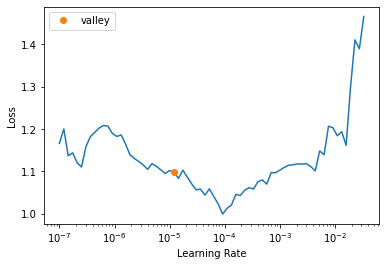

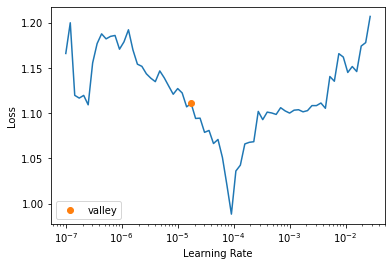

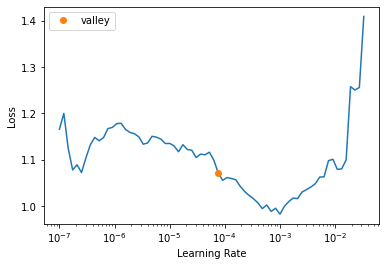

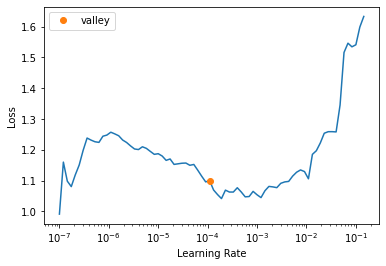

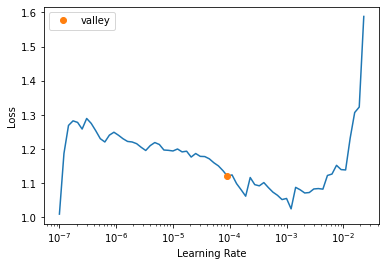

In [17]:
from sklearn.model_selection import StratifiedKFold
from fastai.callback.tracker import SaveModelCallback,EarlyStoppingCallback
import sklearn
from sklearn.metrics import log_loss
tfms = aug_transforms(do_flip = True, flip_vert = False, mult=2.0,size=384,max_rotate=30.0, min_zoom=1.0, max_zoom=1.3, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.1)
skf=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
y_pred_tot=[]
y_pred_tot_5 = []
valid_loglos=[]
i=0
oof = np.zeros((train.shape[0],3))
for train_index, test_index in skf.split(train, train['Label']): 
    train['val_col']=False
    train.loc[test_index,'val_col']=True
    dls = ImageDataLoaders.from_df(train, path='../input/microsoft-rice-disease-classification-challenge',item_tfms=[Resize(384),AlbumentationsTransform(get_train_aug())],batch_tfms=[*tfms,Normalize.from_stats(*imagenet_stats)],valid_col='val_col',seed=50,num_workers=1,val_pct=0,bs=4)
    random_seed(dls,50)
    model = create_model('swin_large_patch4_window12_384', pretrained=True, num_classes=3)
    learn = Learner(dls,model,metrics=[error_rate,accuracy],path='.',cbs=[SaveModelCallback(monitor='valid_loss')])
    random_seed(dls,50)
    best_lr = learn.lr_find()
    learn.fine_tune(20,best_lr.valley)
    #val
    valid =learn.dls.test_dl(train.iloc[test_index]['Image_id'].map(lambda s: '../input/microsoft-rice-disease-classification-challenge/'+s).values)
    val_preds = learn.tta(dl=valid,n=5,use_max=True)
    print(log_loss(train.iloc[test_index]['Label'],val_preds[0]))
    oof[test_index]=val_preds[0]
    #test
    tdl = learn.dls.test_dl(test['Image_id'].map(lambda s: '../input/microsoft-rice-disease-classification-challenge/'+s).values)
    learn.save("model"+str(i))
    preds = learn.tta(dl=tdl,n=5,use_max=True)
    y_pred_tot_5.append(preds)
    y_pred_tot.append(learn.get_preds(dl=tdl))
    print('fold fineshed')
    i=i+1

In [18]:
from sklearn.metrics import log_loss
log_loss(train['Label'].values,oof)

0.08922377233375586

In [19]:
predss=[to_np(x[0])for x in y_pred_tot]
predss


[array([[1.0000000e+00, 1.3519961e-08, 3.4201946e-09],
        [4.7703819e-05, 9.9995184e-01, 4.7680211e-07],
        [9.0546668e-01, 9.4522320e-02, 1.0968833e-05],
        ...,
        [9.9999285e-01, 7.1573645e-06, 5.6388610e-10],
        [9.9999833e-01, 5.8598675e-07, 1.0636207e-06],
        [4.4980694e-02, 8.8803936e-05, 9.5493048e-01]], dtype=float32),
 array([[1.00000000e+00, 1.39385721e-08, 1.81643672e-10],
        [1.04853185e-02, 9.89513993e-01, 7.32038131e-07],
        [9.99234915e-01, 7.64017401e-04, 1.06371738e-06],
        ...,
        [9.99974251e-01, 2.57307365e-05, 1.62700631e-10],
        [9.99999881e-01, 1.38881035e-07, 2.83698913e-08],
        [3.37935588e-03, 5.19672767e-06, 9.96615469e-01]], dtype=float32),
 array([[9.9999797e-01, 1.9540282e-06, 9.6404335e-08],
        [7.9582003e-07, 9.9999917e-01, 4.4965462e-09],
        [9.9985158e-01, 1.4635322e-04, 1.9935610e-06],
        ...,
        [9.9921858e-01, 7.8125542e-04, 8.2916237e-08],
        [9.9984717e-01, 1.523

In [20]:
preds=np.mean(predss,0)
preds

array([[9.9996519e-01, 1.9605503e-05, 1.5238254e-05],
       [2.1144215e-03, 9.9787885e-01, 6.7268506e-06],
       [9.7877532e-01, 2.1211147e-02, 1.3521385e-05],
       ...,
       [9.9919593e-01, 7.9865160e-04, 5.3967497e-06],
       [9.9994338e-01, 4.3444656e-05, 1.3232314e-05],
       [1.5460081e-01, 1.2521118e-04, 8.4527397e-01]], dtype=float32)

In [21]:
submission_from_test = test[['Image_id']]
submission_from_test

,Image_id
0,id_00vl5wvxq3.jpg
1,id_01hu05mtch.jpg
2,id_030ln10ewn.jpg
3,id_03z57m8xht.jpg
4,id_04ngep1w4b.jpg
...,...
1140,id_zrdlgjrq3r.jpg
1141,id_zsfayxwipp.jpg
1142,id_ztvp2l9k3h.jpg
1143,id_zwwcma7hlt.jpg


In [22]:
le.inverse_transform([0,1,2])

array(['blast', 'brown', 'healthy'], dtype=object)

In [23]:
submission_from_test['blast'] = preds[:,0]
submission_from_test['brown'] = preds[:,1]
submission_from_test['healthy'] = preds[:,2]

In [24]:
submission_from_test

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,9.999652e-01,1.960550e-05,1.523825e-05
1,id_01hu05mtch.jpg,2.114421e-03,9.978788e-01,6.726851e-06
2,id_030ln10ewn.jpg,9.787753e-01,2.121115e-02,1.352138e-05
3,id_03z57m8xht.jpg,9.999997e-01,9.225378e-08,1.694033e-07
4,id_04ngep1w4b.jpg,9.969406e-01,2.088984e-04,2.850557e-03
...,...,...,...,...
1140,id_zrdlgjrq3r.jpg,5.549293e-07,3.715392e-04,9.996279e-01
1141,id_zsfayxwipp.jpg,5.276918e-07,9.999938e-01,5.689202e-06
1142,id_ztvp2l9k3h.jpg,9.991959e-01,7.986516e-04,5.396750e-06
1143,id_zwwcma7hlt.jpg,9.999434e-01,4.344466e-05,1.323231e-05


In [25]:
submission_from_test.to_csv("submit_test_0.04.csv",index=False)

In [26]:
np.save('y_pred_tot.npy', y_pred_tot)

/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'TensorImage' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'TensorImage', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [27]:
np.save('y_pred_tot_5.npy', y_pred_tot_5)

In [28]:
submission


,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0
...,...,...,...,...
1140,id_zrdlgjrq3r.jpg,0.0,0.0,0.0
1141,id_zsfayxwipp.jpg,0.0,0.0,0.0
1142,id_ztvp2l9k3h.jpg,0.0,0.0,0.0
1143,id_zwwcma7hlt.jpg,0.0,0.0,0.0
